<font color='blue'>**Preprocess data**</font>

In [ ]:
import pandas as pd
import re
with open('ita.txt', 'r') as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
data.head()

,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
def decontractions(phrase):
  """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""

  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"won\’t", "will not", phrase)
  phrase = re.sub(r"can\’t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)

  phrase = re.sub(r"n\’t", " not", phrase)
  phrase = re.sub(r"\’re", " are", phrase)
  phrase = re.sub(r"\’s", " is", phrase)
  phrase = re.sub(r"\’d", " would", phrase)
  phrase = re.sub(r"\’ll", " will", phrase)
  phrase = re.sub(r"\’t", " not", phrase)
  phrase = re.sub(r"\’ve", " have", phrase)
  phrase = re.sub(r"\’m", " am", phrase)

  return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
data.shape

(354238, 2)

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
print( data.shape )
data.head()

(357866, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
57234,non avevi scelta,<start> you had no choice,you had no choice <end>
34906,faccia ciò che le piace,<start> do what you like,do what you like <end>
100472,perché le foglie sono verdi,<start> why are leaves green,why are leaves green <end>
105156,ho comprato questo per te,<start> i bought this for you,i bought this for you <end>
72882,distribuisci le carte tom,<start> deal the cards tom,deal the cards tom <end>
133869,tutte noi facciamo errori,<start> all of us make mistakes,all of us make mistakes <end>
39551,è soltanto un uccello,<start> it is just a bird,it is just a bird <end>
132493,perché lasciare che vada sprecata,<start> why let it go to waste,why let it go to waste <end>
322459,andiamo a pescare assieme ogni tanto,<start> we go fishing together once in a while,we go fishing together once in a while <end>
283830,sono un vecchio amico del padre di tom,<start> i am an old friend of tom is father,i am an old friend of tom is father <end>


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


In [ ]:
def grader_1(data):
    shape_value = data.shape ==(340044, 3)
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['italian'].values)
    ita_chars = tknizer.word_index.keys()
    diff_chars_ita = set(ita_chars)-set([' ', 't', 'a', 'o', 'r', 'e', 's', 'i', 'n', 'l', 'c', 'm', 'u', 'd', 'p', 'v', 'h', 'g', 'b', 'f', 'è', 'q', 'z', 'ò', 'à', 'y', 'é', 'ì', 'ù', 'k', 'w', '0', 'j', '1', '3', '2', 'x', '9', '5', '8', '4', '6', '7', 'á', 'ñ', 'ê', 'ü', 'ō', 'î', 'ö', 'ú', 'º'])
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['english_inp'].values)
    eng_chars = tknizer.word_index.keys()
    diff_chars_eng = set(eng_chars)-set(['<','>',' ', 'e', 'o', 't', 'i', 'a', 'n', 's', 'h', 'r', 'l', 'd', 'm', 'y', 'u', 'w', 'g', 'c', 'p', 'f', 'b', 'k', 'v', 'j', 'x', 'z', 'q', '0', '1', '3', '2', '9', '5', '8', '6', '4', '7'])
    unique_char_value = (len(diff_chars_eng)==0) and (len(diff_chars_ita)==0)
    return unique_char_value and shape_value

grader_1(data)

False

## <font color='blue'>**Implement custom encoder decoder**</font>

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Task 1: Writing Inference for vanilla Encoder-Decoder

__ 1. please download the model weights from <a href='https://drive.google.com/file/d/1S14Bx8sQHfaCS5XLgc2xeOhhtA84n5je/view?usp=sharing'>here</a>, and load the weights __ <br>
__ 2. Implement the inference i.e given a italian text get the english transilation of it, do this for any random 1000 sentences in train data and 1000 sentences in validation data __ <br>
__ 3. Compute the BLEU score for both train data translations and validation data translations __<br>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd                           = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c
    
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 100
        self.dec_units = dec_units
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix], trainable=False)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM")
        
    def call(self, target_sentances, state_h, state_c):
        #print(target_sentances.shape)
        target_embedd           = self.embedding(target_sentances)
        #print(target_embedd.shape)
        lstm_output, state_h,state_c        = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output,state_h,state_c



In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
train.shape , validation.shape

((286292, 3), (71574, 3))

In [ ]:
# train.shape, validation.shape
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [ ]:
train.head()

,italian,english_inp,english_out
253303,tom è ricco ma mary no,<start> tom is wealthy but mary is not <end>,tom is wealthy but mary is not <end> <end>
298758,lei pensa che dovremmo alzare i prezzi,<start> do you think we should raise prices,do you think we should raise prices <end>
250904,fumare fa male alla salute,<start> smoking is bad for your health,smoking is bad for your health <end>
186220,devo fare qualche acquisto,<start> i have some shopping to do,i have some shopping to do <end>
20969,è delizioso,<start> it is delicious,it is delicious <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
122226,io lo sapevo che stavate scherzando,<start> i knew you were joking,i knew you were joking <end>
259291,come si scrive il tuo cognome,<start> how do you spell your last name,how do you spell your last name <end>
180692,perché le vostre gambe stanno tremando,<start> why are your legs shaking,why are your legs shaking <end>
273646,io mi sto trasformando in uno snob penso,<start> i am turning into a snob i think,i am turning into a snob i think <end>
270933,quante volte è capitato,<start> how many times has that happened,how many times has that happened <end>


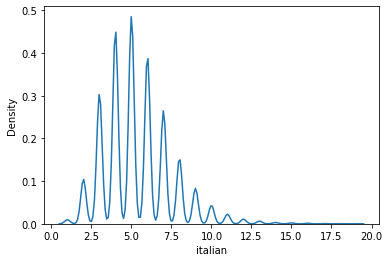

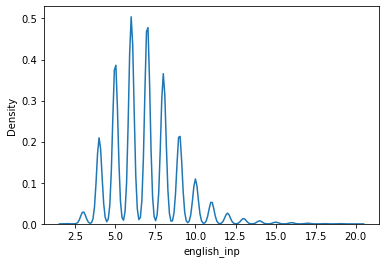

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)


13188
26870


In [ ]:
#vocab_size_eng=13042
#vocab_size_ita=26626

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/25_NLP_attention/data/'

In [ ]:
embeddings_index = dict()
f = open( data_path + 'glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
for word, i in tknizer_eng.word_index.items():
  print( word , i )
  if (i >= 5):
    break

tknizer_eng.index_word[5]

<start> 1
i 2
you 3
tom 4
to 5


'to'

In [ ]:
embedding_matrix.shape

(13189, 100)

In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>'], tknizer_eng.index_word[12751]

(1, 10438, 'lending')

In [ ]:
tknizer_eng.word_index.get('<end>')

10387

In [ ]:
#tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>'], tknizer_eng.index_word[12751]

(1, 10106, 'respective')

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)
batch_size=1024
train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:

class MyModel(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=vocab_size_ita+1, embedding_dim=50, input_length=encoder_inputs_length, enc_units=256)
        self.decoder = Decoder(vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length, dec_units=256)
        self.dense   = Dense(output_vocab_size, activation='softmax')
        
        
    def call(self, data):
        input,output = data[0], data[1]
        print(input.shape,output.shape)
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output,_,_                       = self.decoder(output, encoder_h, encoder_c)
        output                               = self.dense(decoder_output)
        return output

In [ ]:
import os
import random as rn

In [ ]:
os.environ['PYTHONHASHSEED'] = '7'

tf.keras.backend.clear_session()
## Set the random seed values to regenerate the model.
np.random.seed(10)
rn.seed(10)

model  = MyModel(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')


In [ ]:
#model.summary()

In [ ]:
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
train_steps , valid_steps

(279, 69)

In [ ]:

model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10 , \
                    validation_data=train_dataloader, validation_steps=train_steps)



Epoch 1/10
279/279 [==============================] - 95s 339ms/step - loss: 1.4923 - val_loss: 1.4028
Epoch 2/10
279/279 [==============================] - 95s 340ms/step - loss: 1.3281 - val_loss: 1.2443
Epoch 3/10
279/279 [==============================] - 95s 341ms/step - loss: 1.1856 - val_loss: 1.1190
Epoch 4/10
279/279 [==============================] - 95s 340ms/step - loss: 1.0707 - val_loss: 1.0134
Epoch 5/10
279/279 [==============================] - 94s 338ms/step - loss: 0.9742 - val_loss: 0.9258
Epoch 6/10
279/279 [==============================] - 95s 339ms/step - loss: 0.8901 - val_loss: 0.8425
Epoch 7/10
279/279 [==============================] - 95s 340ms/step - loss: 0.8139 - val_loss: 0.7685
Epoch 8/10
279/279 [==============================] - 95s 339ms/step - loss: 0.7426 - val_loss: 0.6995
Epoch 9/10
279/279 [==============================] - 95s 339ms/step - loss: 0.6770 - val_loss: 0.6376
Epoch 10/10
279/279 [==============================] - 95s 340ms/step - l

In [ ]:

model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, \
                    validation_data=train_dataloader, validation_steps=train_steps)



(1024, 20) (1024, 20)
Epoch 1/30
(None, None) (None, None)
(None, None) (None, None)
276/276 [==============================] - 97s 325ms/step - loss: 1.8036 - val_loss: 1.5942
Epoch 2/30
276/276 [==============================] - 90s 326ms/step - loss: 1.5063 - val_loss: 1.4195
Epoch 3/30
276/276 [==============================] - 132s 478ms/step - loss: 1.3537 - val_loss: 1.2772
Epoch 4/30
276/276 [==============================] - 89s 322ms/step - loss: 1.2131 - val_loss: 1.1456
Epoch 5/30
276/276 [==============================] - 89s 324ms/step - loss: 1.0970 - val_loss: 1.0370
Epoch 6/30
276/276 [==============================] - 90s 325ms/step - loss: 0.9967 - val_loss: 0.9453
Epoch 7/30
276/276 [==============================] - 90s 326ms/step - loss: 0.9094 - val_loss: 0.8610
Epoch 8/30
276/276 [==============================] - 91s 329ms/step - loss: 0.8323 - val_loss: 0.7885
Epoch 9/30
276/276 [==============================] - 91s 328ms/step - loss: 0.7633 - val_loss: 0.721

In [ ]:

#model.save_weights( data_path +'saved_model/'+ 'seq_seq_reference_1_acc_0_16.h5')


In [ ]:
#model.load_model( data_path +'saved_model/'+ 'seq_seq_reference_1_acc_0_16.h5')

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [ ]:
def predict(input_sentence):
  
 '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         -> predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         -> pass the predicted_out on to dense layer (model.layers[2])
         -> states=[state_h,state_c]
         -> And get the word using the tokenizer(word index) and then store it in a string.
         -> Update the input_to_decoder with current predictions
  F. Return the predicted sentence
 '''


 return translated_sentence

In [ ]:
def get_ita_pad_sentence( sentence , token_italien):
  seq_ita_1 = token_italien.texts_to_sequences( sentence )
  ita_pad_sent = pad_sequences( seq_ita_1 , maxlen= 100 , dtype='int32', padding='post')
  return ita_pad_sent


In [ ]:
tknizer_eng.word_index['<end>']

10387

In [ ]:
#index = 101
#print( train['italian'][index:index+1].values )
#print( train['english_inp'][index:index+1].values )
#inp_sent_1 = get_ita_pad_sentence( train['italian'][index:index+1] , tknizer_ita )
#print( inp_sent_1[0][0:10] )

#encoder_state_value=model.layers[0]( inp_sent_1 )
#encoder_out_put , h_stete , c_stete  = model.layers[0]( inp_sent_1 )
#encoder_state_value=encoder_state_value[1:]

#print( encoder_state_value[0][0:1].shape , encoder_state_value[0][1:1].shape ,encoder_state_value[0][2:3].shape )
#print( encoder_state_value )

#target_word=np.zeros((1,1))
# <start>:1 , <end>:2 -- 
#target_word[0,0]=1

#inference(encoder_out_put , h_stete , c_stete)
#target_word
#out_put.shape
#tknizer_eng.index_word[1]
#np.array( [1] )
#h_stete.shape , c_stete.shape
index = 119
#print( train['italian'][index:index+1].values )
#print( str(train['english_inp'][index:index+1].values)[9:] )
#inp_sent_1 = get_ita_pad_sentence( train['italian'][index:index+1] , tknizer_ita )
#print( inp_sent_1 )
#encoder_out_put , h_stete , c_stete  = model.layers[0]( inp_sent_1 )
#inference( train['italian'][index:index+1].values )
#np.argmax( np.array( [1.8414561e-08, 1.6834068e-08 ,2.3598440e-01 , 1.8017859e-08 ,1.8367379e-08,1.5047453e-08]), 0 )

trans_sent = inference( ['ti ricordi di me'])
trans_sent

' do you remember me'

In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:

button = widgets.Button(description="Transate !")
inp = widgets.Text(description='Enter Italian:')
eng_lbl = widgets.Label(value='English :')
display(inp)
display(button)
display( eng_lbl )

#Box = widgets.HBox([button,inp])

value_list = []

def on_button_clicked(b):
    #value_list.append(inp.value)
    #print(inp.value)
    trans_sent = inference( ['' + str(inp.value) ])
    #print(trans_sent)
    eng_lbl.value = 'English : ' + str(trans_sent)

button.on_click(on_button_clicked)
#Box

Text(value='', description='Enter Italian:')

Button(description='Transate !', style=ButtonStyle())

Label(value='English :')

In [ ]:
#ita_sent = input('Enter the italian sentence: ')
#ita_sent

In [ ]:
def inference( sentence ):
  '''
    Function that takes Italian sequence and returns English sequence
  '''
  
  seq_ita_1 = tknizer_ita.texts_to_sequences( sentence )
  italian_padded_sent = pad_sequences( seq_ita_1 , maxlen= 100 , dtype='int32', padding='post')

  #seq=seq.reshape(-1,9)
  # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
  #encoder_state_value=encoder_model.predict(seq)
  encoder_out_put , state_h, state_c  = model.layers[0]( italian_padded_sent )
  #encoder_state_value=encoder_state_value[1:]
  # encoder_state_value[0] -- hidden_state -- shape (None,256)
  # encoder_state_value[1] -- cell_state -- shape (None,256)

  # Target word
  target_word=np.zeros((1,1))
  # <start>:1 , <end>:2 -- 
  # <start>:1, <end>:10387
  target_word[0,0]=1
  
  stop_condition=False
  sent=''
  k=0
  while not stop_condition:

      # We are giving a target_word which represents <start> and encoder_states to the decoder_model
      #output,state_h,state_c=decoder_model.predict([target_word]+encoder_state_value)
      dec_output,state_h,state_c = model.layers[1]( np.array( target_word ) , state_h,state_c)
      # As the target word length is 1. We will only have one time step
      #encoder_state_value=[state_h,state_c]
      # Output shape (1,eng_vocab_size). Find the word which the decoder predicted with max_probability
      dense_output = model.layers[2]( dec_output )
      #print( dense_output[0][0] )
      #output=np.argmax(output,-1)
      output=np.argmax( dense_output[0][0] , 0 )
      #print(output)
      # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
      #tknizer_eng.index_word[5] , eng_index_word
      #sent=sent + ' ' + tknizer_eng.index_word[int(output)]
      k+=1
      # If the max_length of the sequence is reached or the model predicted 2 (<end>) stop your model
      if k>10 or output==int(tknizer_eng.word_index['<end>']):
        stop_condition=True
      else :
        sent=sent + ' ' + tknizer_eng.index_word[int(output)]
      
      target_word=output.reshape(1,1)
  
  return sent


In [ ]:
output=predict('si guardi attorno')
print(output)

(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
look around


In [ ]:
output=predict('non vado daccordo con quel tipo')
print(output)

(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
i do not get along with that one


In [ ]:
predict('lei che cosa vuole sapere')

(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)
(1, 1)
(1, 1, 100)


'what do you want to know'